In [8]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tqdm import tqdm
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score

np.random.seed(42)

# Custom imports
from lattice import Lattice

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## ----------------------- CODE FROM PROJECT DESCRIPTION -----------------------

In [9]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


### Generate spin configurations

In [10]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data_big.pkl"

def get_lattices(T, N=10, Nlattices=25, Nthermal=200):
    """
    Generates a set of lattices at a given temperature
    
    Args:
        T (float): temperature of the lattice
        N (int): the lattice size
        Nlattices (int): the number of lattices to generate
        Nthermal (int): the number of steps to simulate thermalization
    """
    lattices = []
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
        lattices.append(lat.lattice)
    return round(T, 4), lattices

if not os.path.exists(fname):
    pool = ThreadPool(6)
    Ts = np.arange(5.0,1.0,-0.1)
    d_data = {}
    for T, lattices in pool.imap_unordered(get_lattices, Ts):
        print(T)
        d_data[T] = lattices

    with open(fname,"wb") as fhout:
        pickle.dump(d_data,fhout)
    print(f">>> Dumped to {fname}")

else:
    d_data = pickle.load(open(fname,"rb"))
    print(">>> Loaded from {}".format(str(fname)))

>>> Loaded from ising_config_data_big.pkl


In [11]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the NN / CNN to learn the concept of temperature/magnetization/etc.

In [12]:
# function to split the data
def split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3, test_size=0,random_state=42):
    """
    Splits the data into train and test sets according to the settings.
    
    Either using sklearn train_test_split (test_size).  
    Or, alternatively, using T>Thi and T<Tlo data as training data and Tlo < T < Thi as predictions/test.
    """
    if test_size:
        print(f"Using sklearn to split data. Test size: {test_size*100:}%")
        X_train, X_test, y_train, y_test, T_train, T_test = \
          train_test_split(X_data, y_data, T_data, test_size=test_size, random_state=random_state)
    elif (Thi and Tlo):
        print(f"Using T>{Thi} and T<{Tlo} as training data.")
        train_set = np.logical_or(T_data>=Thi,T_data<=Tlo)
        test_set = np.logical_not(train_set)
        X_train = X_data[train_set]
        X_test = X_data[test_set]
        y_train = y_data[train_set]
        y_test = y_data[test_set]
        T_train = T_data[train_set]
        T_test = T_data[test_set]
    else:
        print("No rule to split data.")
        return None
        
    print(f"...Training samples: {X_train.shape[0]}")
    print(f"...Testing samples:  {X_test.shape[0]}")
    return(X_train, X_test, y_train, y_test, T_train, T_test)

## ----------------- END OF CODE FROM PROJECT DESCRIPTION -----------------

## Task 2: DNN

### Load the data 

In [13]:
X_train, X_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data,test_size=0.3)

Using sklearn to split data. Test size: 30.0%
...Training samples: 4200
...Testing samples:  1800


### Define the DNN -  Train and predict

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


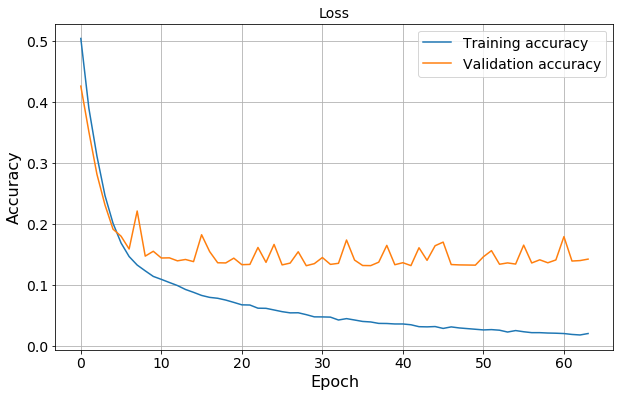

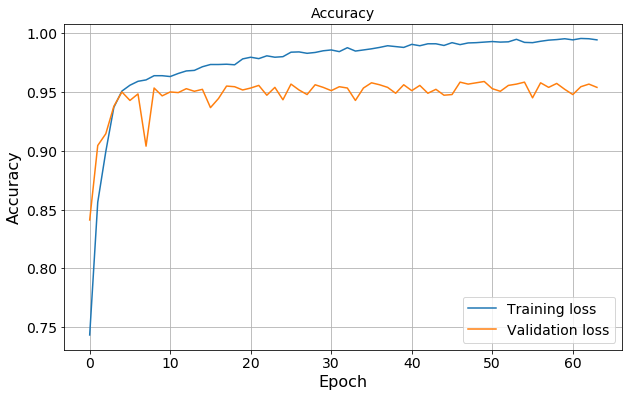

In [64]:
def create_dnn(data):
    model = Sequential()
    model.add(Flatten(input_shape=(data.shape[1], data.shape[2])))  # Flatten the 10x10 grid
    #model.add(Dropout(0.1))  # Dropout to try to increase generalization
    model.add(Dense(100,
                    activation='relu')) # Add a dense layer with ten neurons
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

dnn = create_dnn(X_train)
dnn.summary()

# Fit on X_train and y_train
hist = dnn.fit(x=X_train, 
                  y=y_train,
                  validation_data=(X_test, y_test),
                  epochs=64,
                  batch_size=64,
                  verbose=0)

# Plot training and test performance
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(hist.history['loss'], label='Training accuracy')
ax1.plot(hist.history['val_loss'], label='Validation accuracy')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Loss")
ax1.grid()
ax1.legend(loc='best')

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(hist.history['acc'], label='Training loss')
ax2.plot(hist.history['val_acc'], label='Validation loss')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.grid()
ax2.legend(loc='best')

Around 100 nodes works fairly well, dropout seems to increase noisyness. Overfits fairly hard after around 10 epochs. 

### Predict the critical temperature

The predicted critical temperature is 2.19 K.


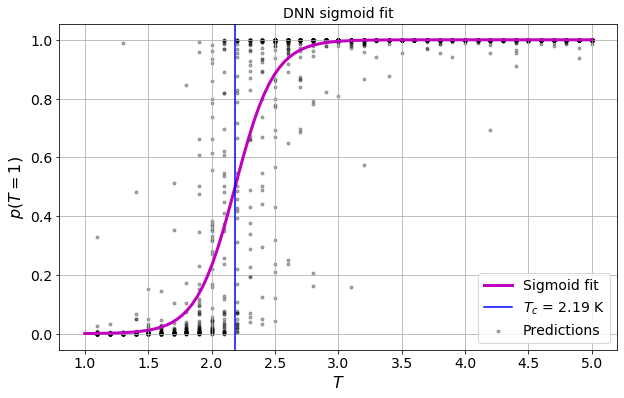

In [125]:
def sigmoid_fun(x, a, b):
    '''a is scale, b is location. Location is where the curve crosses 0.5.'''
    return 1/(1+np.exp(-a*(x-b)))
    
    

# Make a prediction on the test set. These corresponds to our temperatures T
T_pred = (dnn.predict(X_test)).squeeze()  # Squeeze the unnecessary dimension from predict

# Fit a sigmoid to our predictions
popt, pcov = curve_fit(sigmoid_fun, T_test, T_pred, p0=[3, 1], method='dogbox')
# The critical temperature is where p(T=1) = 0.5. This is the same as the location parameter b.
t_c_fit = popt[1]
print(f'The predicted critical temperature is {t_c_fit:.2f} K.')

#res = minimize_scalar(objective, bracket=(4, 10), args=tuple(popt2))

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(T_test, T_pred, marker='.', c='k', alpha=0.3, label='Predictions')
T_space = np.linspace(1, 5, 100)
ax.plot(T_space, sigmoid_fun(T_space, popt[0], popt[1]), color='m', linewidth=3, label="Sigmoid fit")
ax.axvline(t_c_fit, color='b', label=fr'$T_c$ = {t_c_fit:.2f} K')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$p(T=1)$')
ax.set_title('DNN sigmoid fit')
ax.grid()
ax.legend(loc='best')

## Task 3: CNN

### Load the data 

In [160]:
X_train, X_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3)

Using T>4.7 and T<1.3 as training data.
...Training samples: 1050
...Testing samples:  4950


In [161]:
# prepare for CNN input
img_rows, img_cols = 10, 10
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

#y_train = keras.utils.to_categorical(y_train, 2)
#y_test = keras.utils.to_categorical(y_test, 2)
print(y_train.shape)

(1050,)


**TODO** Use the input as it is intended - why does he do it like this?

### Define the CNN -  Train and predict

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 8, 8, 64)          640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 3, 32)          8224      
_________________________________________________________________
flatten_47 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 289       
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________


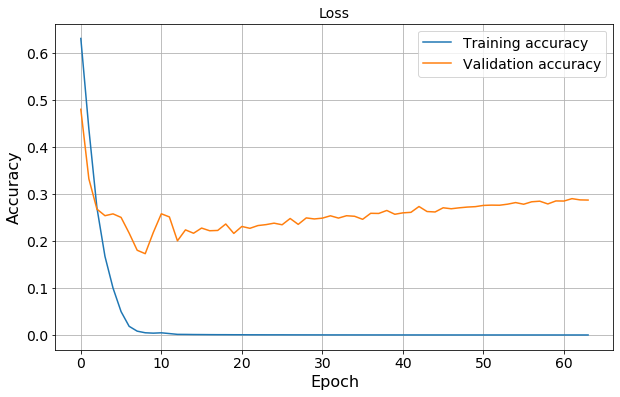

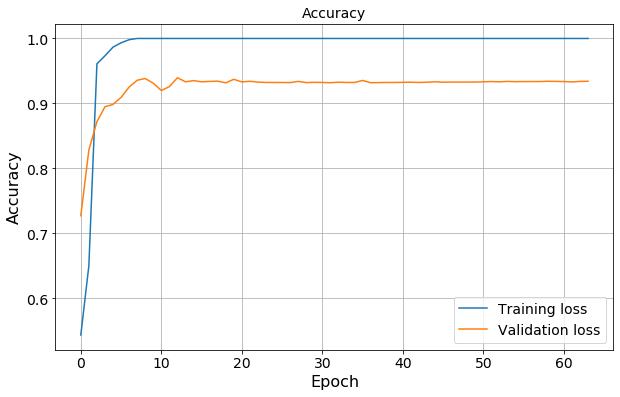

In [155]:
def create_cnn(data):
    model = Sequential()
    model.add(Conv2D(64, 
                     kernel_size=3, 
                     activation='relu', 
                     input_shape=(data.shape[1], data.shape[2],1)))
    # Add max pooling
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32,
                     kernel_size=2, 
                     activation='relu')) 
    # Add another conv
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

cnn = create_cnn(X_train)
cnn.summary()

# Fit on X_train and y_train
hist = cnn.fit(x=X_train, 
                  y=y_train,
                  validation_data=(X_test, y_test),
                  epochs=64,
                  batch_size=64,
                  verbose=0)

# Plot training and test performance
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(hist.history['loss'], label='Training accuracy')
ax1.plot(hist.history['val_loss'], label='Validation accuracy')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Loss")
ax1.grid()
ax1.legend(loc='best')

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(hist.history['acc'], label='Training loss')
ax2.plot(hist.history['val_acc'], label='Validation loss')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.grid()
ax2.legend(loc='best')

### Predict the critical temperature

The predicted critical temperature is 2.34 K.


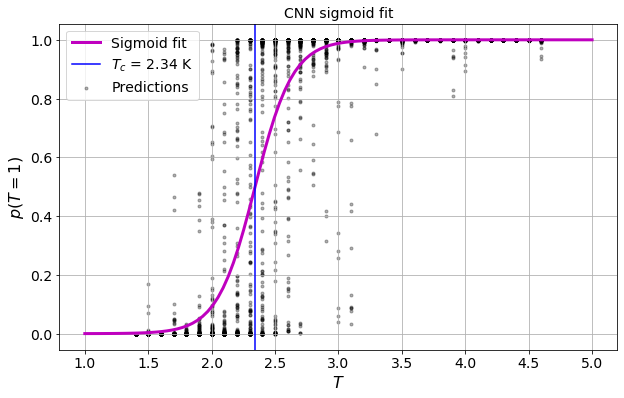

In [156]:
# Make a prediction on the test set. These corresponds to our temperatures T
T_pred = (cnn.predict(X_test)).squeeze()  # Squeeze the unnecessary dimension from predict

# Fit a sigmoid to our predictions
popt, pcov = curve_fit(sigmoid_fun, T_test, T_pred, p0=[3, 1], method='dogbox')
# The critical temperature is where p(T=1) = 0.5. This is the same as the location parameter b.
t_c_fit = popt[1]
print(f'The predicted critical temperature is {t_c_fit:.2f} K.')

#res = minimize_scalar(objective, bracket=(4, 10), args=tuple(popt2))

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(T_test, T_pred, marker='.', c='k', alpha=0.3, label='Predictions')
T_space = np.linspace(1, 5, 100)
ax.plot(T_space, sigmoid_fun(T_space, popt[0], popt[1]), color='m', linewidth=3, label="Sigmoid fit")
ax.axvline(t_c_fit, color='b', label=fr'$T_c$ = {t_c_fit:.2f} K')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$p(T=1)$')
ax.set_title('CNN sigmoid fit')
ax.grid()
ax.legend(loc='best')